## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
dataset_path = 'melanoma-384x384'

config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "BASE_MODEL_PATH": 'imagenet11k',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 384,
 'WIDTH': 384,
 'CHANNELS': 3,
 'BATCH_SIZE': 256,
 'EPOCHS': 20,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'BASE_MODEL_PATH': 'imagenet11k',
 'DATASET_PATH': 'melanoma-384x384'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 2e-05


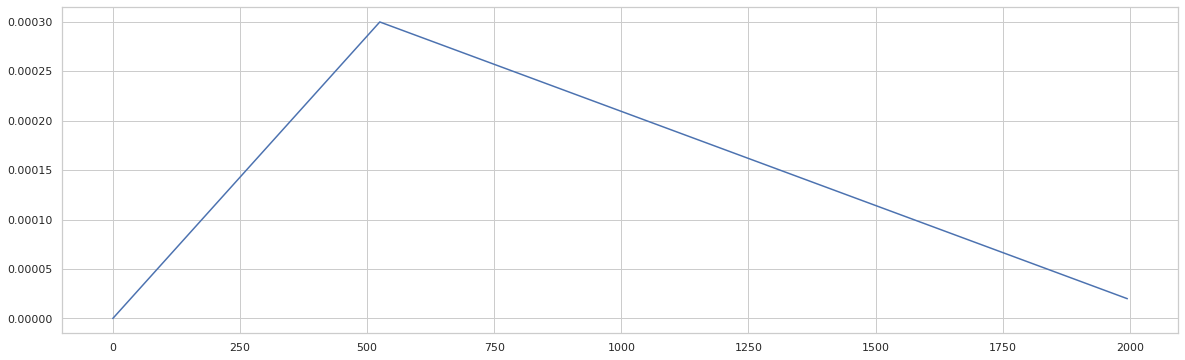

In [8]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get('resnet152')
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_PATH'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [10]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    tf.tpu.experimental.initialize_tpu_system(tpu)
#     K.clear_session()
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = f'model_fold_{n_fold}.h5'
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es], 
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
234332160/234326024 [==============================] - 8s 0us/step
Epoch 1/20
97/97 - 89s - loss: 0.5811 - auc: 0.6133 - val_loss: 22.1790 - val_auc: 0.5000
Epoch 2/20
97/97 - 60s - loss: 0.1712 - auc: 0.8014 - val_loss: 5.6822 - val_auc: 0.5107
Epoch 3/20
97/97 - 59s - loss: 0.1674 - auc: 0.8464 - val_loss: 0.1944 - val_auc: 0.4483
Epoch 4/20
97/97 - 51s - loss: 0.1671 - auc: 0.8291 - val_loss: 0.4461 - val_auc: 0.4689
Epoch 5/20
97/97 - 50s - loss: 0.1658 - auc: 0.8609 - val_loss: 0.2181 - val_auc: 0.5052
Epoch 6/20
97/97 - 50s - loss: 0.1659 - auc: 0.8495 - val_loss: 0.2351 - val_auc: 0.5477
Epoch 7/20
97/97 - 51s - loss: 0.1662 - auc: 0.8581 - val_loss: 0.2360 - val_auc: 0.5157
Epoch 8/20
97/97 - 59s - loss: 0.1630 - auc: 0.8846 - val_loss: 0.1937 - val_auc: 0.6715
Epoch 9/20
97/97 - 56s - loss: 0.1626 - auc: 0.8959 - val_loss: 0.1824 - val_auc: 0.7941
Epoch 10/20
97/97 - 48s - loss: 0.1601 - auc: 0.8972 - val_loss: 0.1872 - val_auc: 0.7659
Epoch 11/20
97/97 - 56s - loss: 

## Model loss graph

Fold: 1


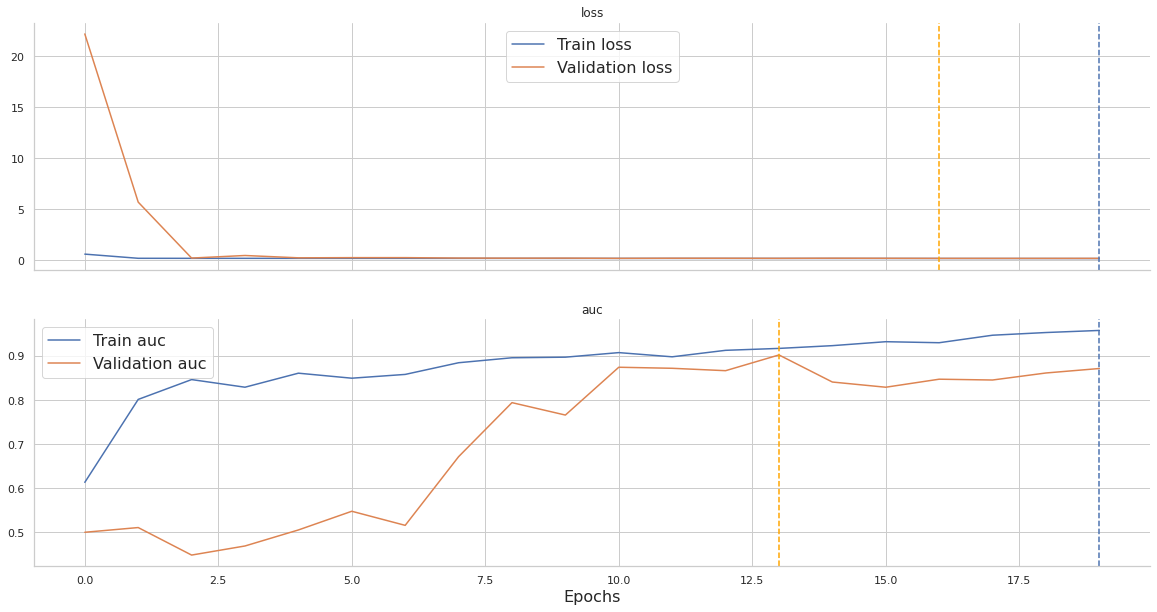

Fold: 2


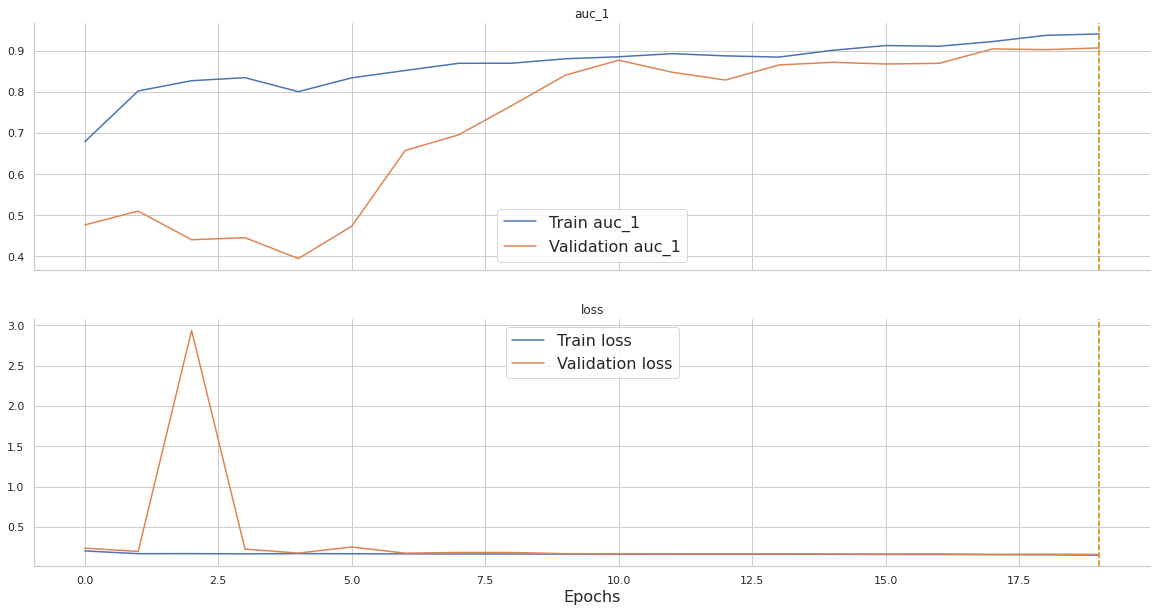

Fold: 3


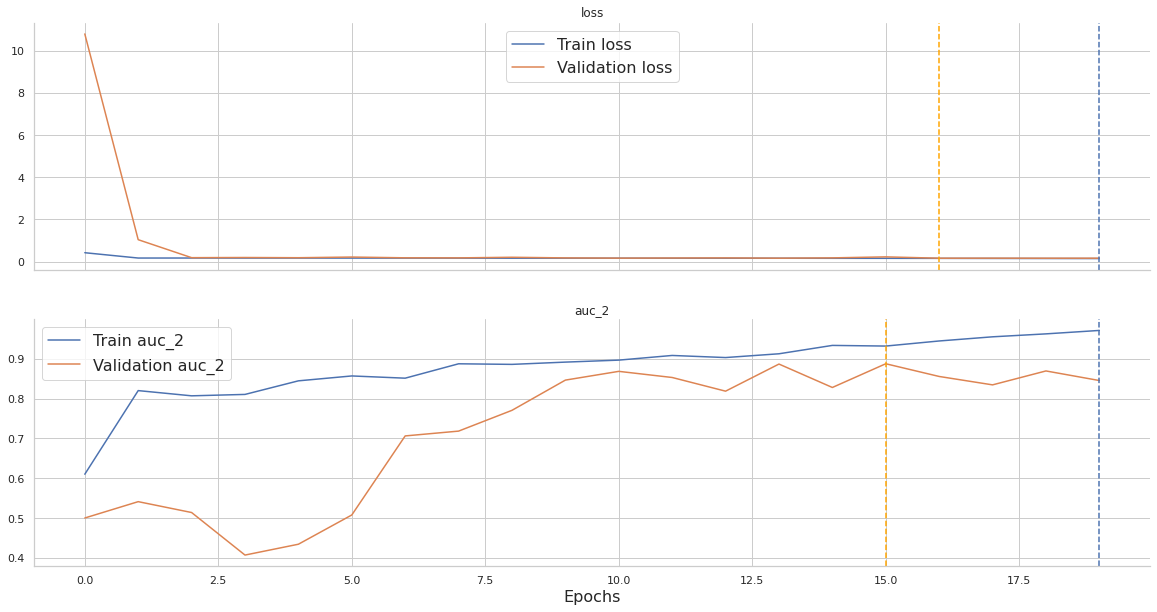

Fold: 4


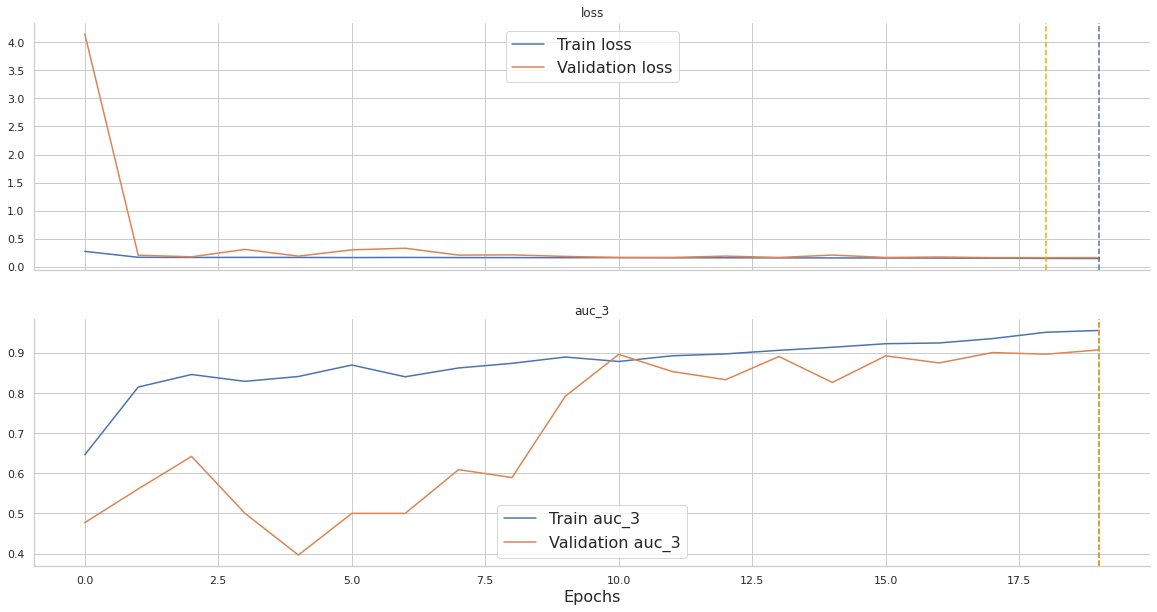

Fold: 5


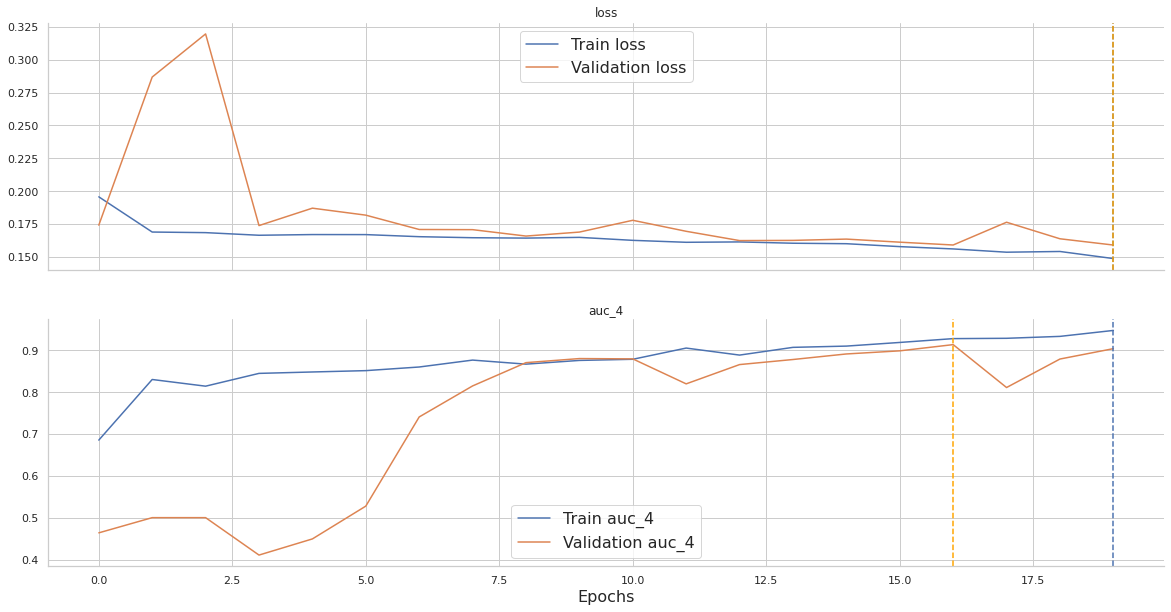

In [11]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

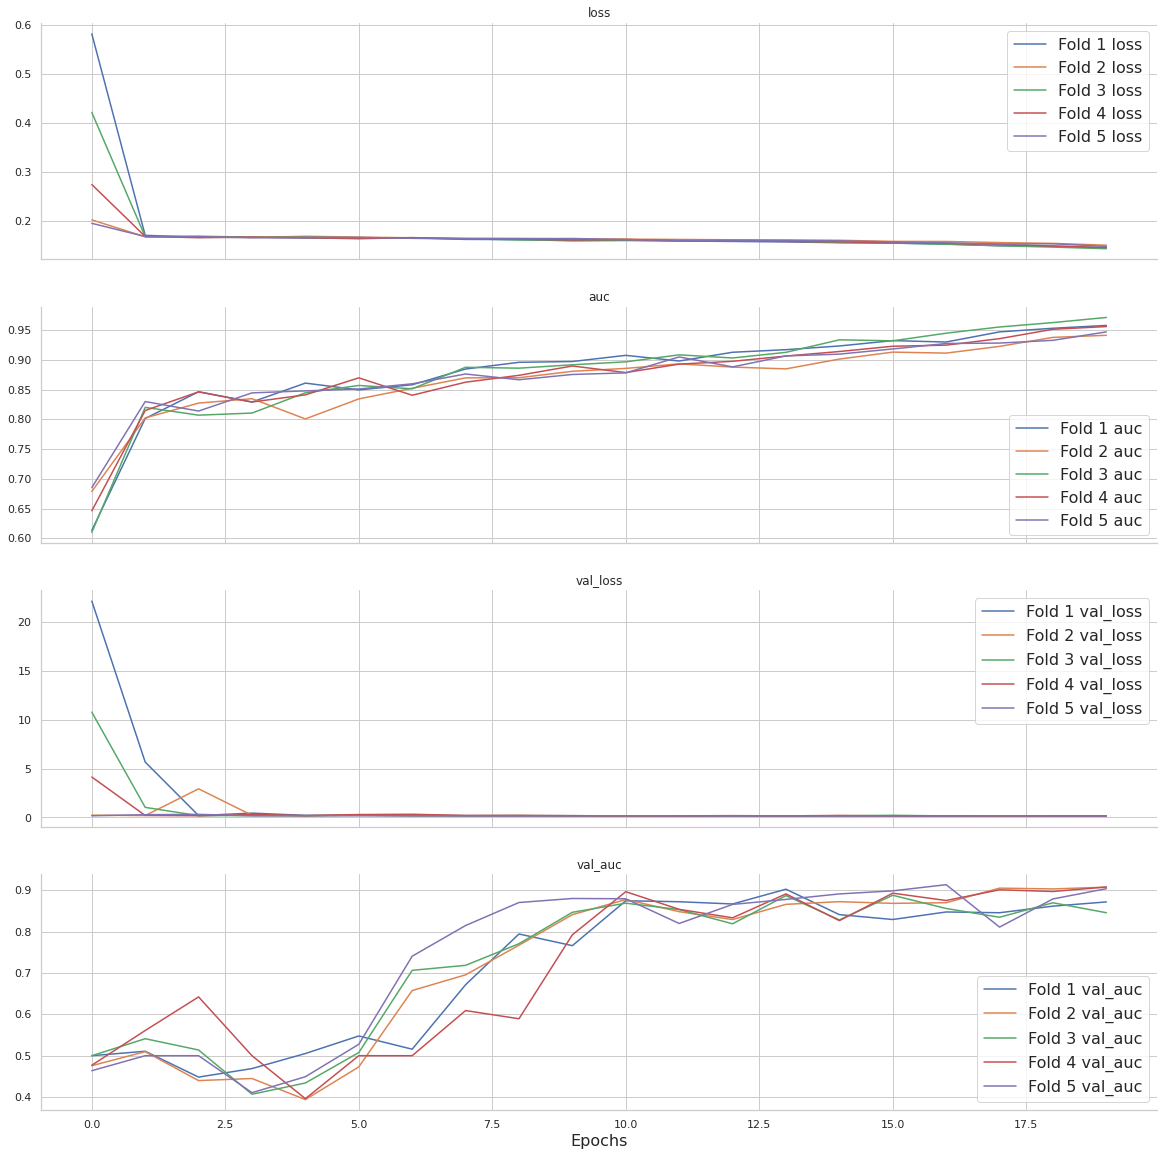

In [12]:
plot_metrics_agg(history_list, config['N_FOLDS'])

# Model evaluation

In [13]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.977126,0.888166,0.088960,0.987786,0.868806,0.960651,0.908409,0.991036,0.847719,0.973218,0.907111,0.972942,0.908786
Accuracy,0.990506,0.982522,0.007983,0.990983,0.982979,0.987961,0.982456,0.993163,0.982456,0.990491,0.981138,0.989931,0.983583
Precision,0.919487,0.520338,0.399149,0.969957,0.500000,0.871287,0.513514,0.958466,0.547619,0.872414,0.446809,0.925311,0.593750
Recall,0.504583,0.164960,0.339623,0.510158,0.085106,0.371308,0.172727,0.636943,0.203540,0.536017,0.187500,0.468487,0.175926
F1-score,0.648147,0.247262,0.400884,0.668639,0.145455,0.520710,0.258503,0.765306,0.296774,0.664042,0.264151,0.622036,0.271429
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [14]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.977126,0.888166,0.088960,0.987786,0.868806,0.960651,0.908409,0.991036,0.847719,0.973218,0.907111,0.972942,0.908786
male,0.979309,0.904522,0.074787,0.990388,0.882405,0.967883,0.920543,0.992964,0.879675,0.974205,0.913105,0.971105,0.926883
female,0.973329,0.856216,0.117114,0.983005,0.845434,0.949399,0.870341,0.987877,0.779298,0.970775,0.901084,0.975592,0.884921
head/neck,0.981562,0.844457,0.137106,0.976095,0.856860,0.969178,0.831378,0.991512,0.833437,0.987456,0.857621,0.983571,0.842988
upper extremity,0.980561,0.913076,0.067485,0.988050,0.905670,0.960164,0.930133,0.994117,0.935287,0.982814,0.896239,0.977662,0.898053
lower extremity,0.963550,0.851603,0.111947,0.991161,0.835551,0.942443,0.854639,0.984767,0.779017,0.945755,0.903028,0.953622,0.885778
torso,0.980620,0.908536,0.072084,0.988303,0.873639,0.965730,0.954482,0.992298,0.854273,0.979533,0.927323,0.977236,0.932960
0 <= age < 26,0.951455,0.832801,0.118654,0.988207,0.900000,0.900264,0.904292,0.985202,0.818345,0.928153,0.746725,0.955449,0.794643
26 <= age < 40,0.958223,0.838536,0.119688,0.979822,0.818428,0.936705,0.855550,0.994244,0.721843,0.947839,0.879360,0.932507,0.917498


# Confusion matrix

Fold: 1


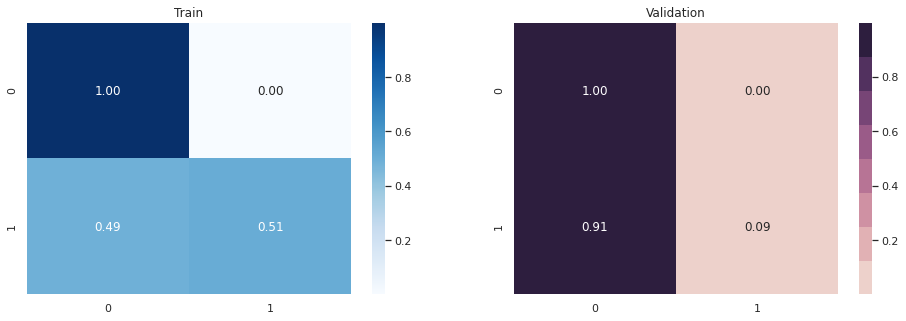

Fold: 2


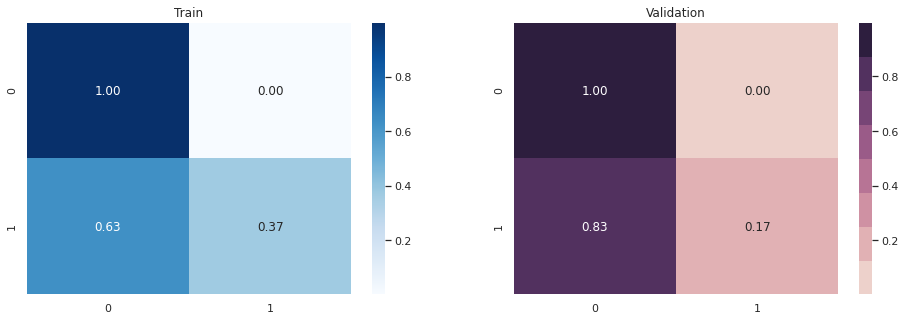

Fold: 3


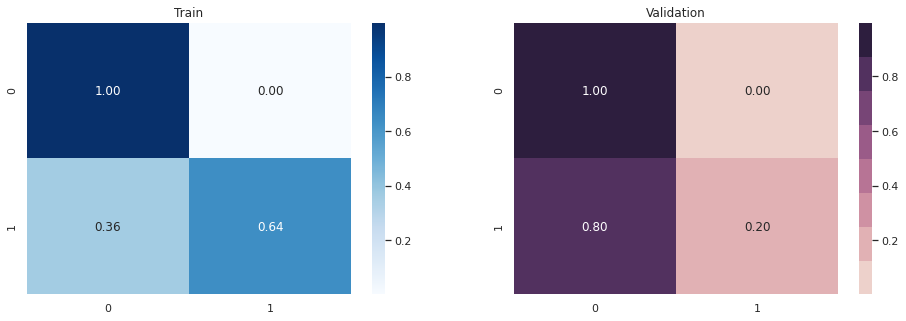

Fold: 4


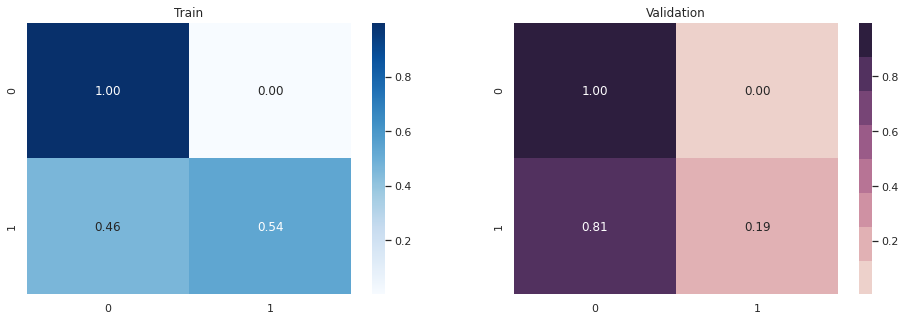

Fold: 5


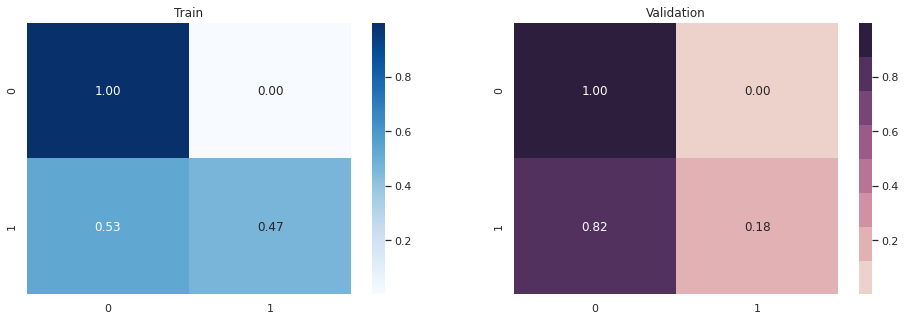

In [15]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [16]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.024441,0.021019,0.017505,0.035153,0.025006,0.023523
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.026526,0.026197,0.022886,0.033123,0.029528,0.020894
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.026183,0.013199,0.026268,0.040574,0.027414,0.023460
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.033649,0.029696,0.022799,0.046603,0.032144,0.037005
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.025565,0.023216,0.023713,0.034995,0.025959,0.019943
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.024752,0.019948,0.021130,0.028858,0.027676,0.026146
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.029700,0.021600,0.026688,0.035604,0.032975,0.031632
7,ISIC_0075663,female,35.0,torso,unknown,0,0.022686,0.014027,0.032167,0.018482,0.026758,0.021996
8,ISIC_0075914,male,30.0,torso,unknown,0,0.023594,0.019431,0.027100,0.025897,0.025148,0.020395
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.023099,0.016180,0.023641,0.025054,0.027309,0.023310


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.144251,0.021446,0.065967,0.211955,0.298367,0.123519
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.518210,0.053976,0.334776,0.760543,0.849751,0.592003
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.189935,0.337765,0.162162,0.039680,0.352596,0.057471
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.083162,0.021865,0.097388,0.117812,0.055676,0.123067
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.529878,0.170077,0.470042,0.870301,0.587415,0.551557
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.543879,0.955710,0.100282,0.891421,0.071792,0.700191
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.184219,0.466442,0.058673,0.216501,0.130609,0.048870
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.580864,0.048252,0.494585,0.459912,0.975967,0.925603
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.122363,0.063412,0.032854,0.068150,0.357074,0.090327
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.095720,0.144425,0.039328,0.031299,0.049535,0.214015


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.518210,0.053976,0.334776,0.760543,0.849751,0.592003
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.529878,0.170077,0.470042,0.870301,0.587415,0.551557
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.543879,0.955710,0.100282,0.891421,0.071792,0.700191
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.580864,0.048252,0.494585,0.459912,0.975967,0.925603
607,ISIC_0286360,male,60.0,upper extremity,melanoma,1,0.684403,0.874808,0.483573,0.998772,0.112464,0.952397
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.864549,0.997971,0.808314,0.575082,0.980597,0.960783
1205,ISIC_0464315,male,70.0,torso,unknown,0,0.611271,0.854122,0.620598,0.301684,0.581212,0.698738
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.960224,0.942726,0.905307,0.993636,0.991990,0.967460
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.917066,0.997143,0.817794,0.958572,0.915248,0.896574
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.832303,0.993575,0.940823,0.835174,0.959922,0.432021


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 277
Train positive correct predictions: 267


# Make predictions

In [17]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


In [18]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
#     K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


# Visualize test predictions

In [19]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 36|10946
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.028901
1,ISIC_0052349,male,40.0,lower extremity,0.025189
2,ISIC_0058510,female,55.0,torso,0.025812
3,ISIC_0073313,female,50.0,torso,0.029259
4,ISIC_0073502,female,45.0,lower extremity,0.048602
5,ISIC_0074618,male,50.0,lower extremity,0.030608
6,ISIC_0076801,male,45.0,upper extremity,0.028109
7,ISIC_0077586,male,50.0,lower extremity,0.038091
8,ISIC_0082004,female,45.0,torso,0.034255
9,ISIC_0082785,male,65.0,lower extremity,0.031415


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
403,ISIC_0481105,male,80.0,torso,0.737795
1408,ISIC_1364884,female,35.0,upper extremity,0.714744
1677,ISIC_1593714,female,50.0,lower extremity,0.649968
1764,ISIC_1670692,male,50.0,torso,0.544276
2214,ISIC_2098553,male,55.0,torso,0.744844
2739,ISIC_2560699,male,70.0,torso,0.875525
3045,ISIC_2839742,male,70.0,upper extremity,0.965911
3193,ISIC_2995868,male,90.0,head/neck,0.638560
3463,ISIC_3231502,male,25.0,upper extremity,0.558761
3634,ISIC_3412012,male,60.0,lower extremity,0.611701


# Test set predictions

In [20]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.028901
1,ISIC_0052349,0.025189
2,ISIC_0058510,0.025812
3,ISIC_0073313,0.029259
4,ISIC_0073502,0.048602
5,ISIC_0074618,0.030608
6,ISIC_0076801,0.028109
7,ISIC_0077586,0.038091
8,ISIC_0082004,0.034255
9,ISIC_0082785,0.031415


,target
count,10982.000000
mean,0.043398
std,0.054409
min,0.013906
25%,0.026784
50%,0.029828
75%,0.038151
max,0.965911
